In [1]:
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt

import numpy as np
from utils import filt_decompose

In [2]:
plt.rcParams['font.size']=14
plt.rcParams['axes.labelsize']='large'
plt.rcParams['pcolor.shading']='auto'


In [3]:
# Load raw csv
csvfile = '/data/jupyter-ubuntu/TIDE/NRA/NRA_airgap_RAW_2023.csv.gz'
df = pd.read_csv(csvfile, header=7, 
                 #nrows = 31*2*86400,
                 parse_dates=True,
                 sep=',', index_col=0, compression='gzip')

df.rename(columns={'6ee24280-dc14-11ea-ab29-07bcbab2eee7': 'airgap'}, inplace=True)
df
ds = df.to_xarray()
ds


<xarray.Dataset>
Dimensions:            (Timestamp (UTC+8): 62855825)
Coordinates:
  * Timestamp (UTC+8)  (Timestamp (UTC+8)) datetime64[ns] 2023-01-01T00:00:00...
Data variables:
    airgap             (Timestamp (UTC+8)) float64 26.49 26.73 ... 24.94 24.96

In [7]:
%%time
ds.to_netcdf('/data/jupyter-ubuntu/TIDE/NRA/NRA_airgap_RAW_2023.nc',
    encoding={'airgap':{"compression": "zlib", "complevel": 9}})

CPU times: user 2.69 s, sys: 1.16 s, total: 3.85 s
Wall time: 7.97 s


In [8]:
ds = xr.open_dataset('/data/jupyter-ubuntu/TIDE/NRA/NRA_airgap_RAW_2023.nc')

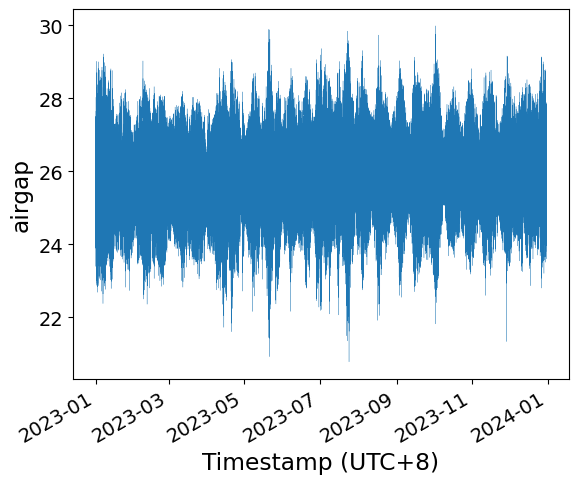

In [9]:
ds['airgap'].plot(lw=0.2)

In [10]:
time = ds['Timestamp (UTC+8)'].values

dt = (time[1:]-time[:-1]).mean()
dtsec = dt.astype(float)*1e-9
dtsec, 1/dtsec

(0.500345035, 1.9986208117364448)

In [11]:
tfloat = time.astype(float)
tfloat[1:] - tfloat[0:-1]

array([5.00000000e+08, 5.00000000e+08, 5.00000000e+08, ...,
       5.00000000e+08, 5.00000000e+08, 5.09999872e+08])

In [12]:
filt_decompose?

Signature: filt_decompose(xraw, dt, b1=122400, b2=14400)
Docstring: <no docstring>
File:      /data/jupyter-ubuntu/ProjectsActive/SWOT_NAust/NOTEBOOKS/utils.py
Type:      function

In [13]:
dtsec = 0.5
y = ds['airgap']-ds['airgap'].mean()
yf = filt_decompose(y, 1/dtsec, b1=8*3600, b2=120)


(array([19358., 19417., 19478., 19539., 19601., 19662., 19723.]),
 [Text(19358.0, 0, '2023-01'),
  Text(19417.0, 0, '2023-03'),
  Text(19478.0, 0, '2023-05'),
  Text(19539.0, 0, '2023-07'),
  Text(19601.0, 0, '2023-09'),
  Text(19662.0, 0, '2023-11'),
  Text(19723.0, 0, '2024-01')])

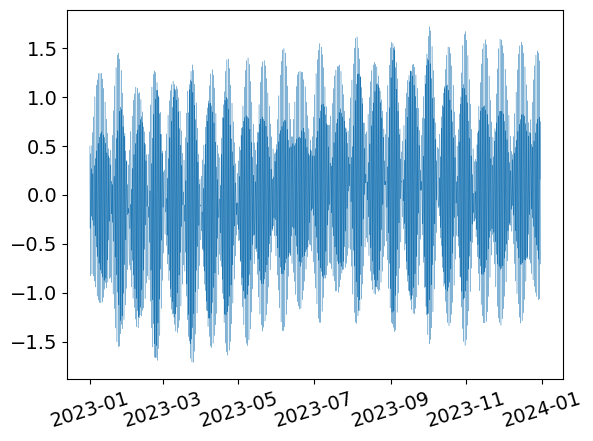

In [24]:
ss = 120
plt.figure()
plt.plot(time[::ss], yf[::ss,0], lw=0.2)
plt.xticks(rotation=17)
# plt.xlim(np.datetime64('2023-01-07 15:00:00'), np.datetime64('2023-01-07 18:00:00'))

In [26]:
# Create a down-scaled output dataset
dsout = xr.DataArray(yf[::ss,0]+yf[::ss,1], coords={'time':time[::ss]})
xr.Dataset({'airgap':dsout}).to_netcdf('/data/jupyter-ubuntu/TIDE/NRA/NRA_airgap_RAW_2023_60s.nc')